In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df_final = pd.read_pickle("Data/df_with_history.pkl")

In [3]:
# Round all differences
df_final["difference"] = [np.round(diff) for diff in df_final["difference"]]

In [4]:
# Create bins
bins = np.arange(0,31,1)
bins = np.append(bins, np.max(df_final["difference"]))

In [5]:
# Cut the difference column into bins and save that as a new column
test = pd.cut(df_final["difference"], bins=bins, labels=bins[1:])
test = test.rename("difference_bin")

In [7]:
df_binned = pd.concat([df_final, test], axis=1)

In [8]:
# Label encode the binned variable
le = LabelEncoder()
le.fit(test.cat.categories)

print(list(le.classes_))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 1179.0]


In [9]:
df_binned["difference_bin"] = le.transform(df_binned["difference_bin"])

In [10]:
df_binned["difference_bin"] = df_binned["difference_bin"].astype("category")

In [11]:
X = df_binned.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                     "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee",
                     "t_5", "t_4", "t_3", "t_2", "t_1"]]

y = df_binned.loc[:, "difference_bin"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [14]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

X_val = scaler.fit_transform(X_val)
y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))

In [15]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(16,), activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

In [16]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics="accuracy")
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), use_multiprocessing=True)

Epoch 1/15
5956/5956 [==============================] - 11s 2ms/step - loss: -0.8458 - accuracy: 0.0447 - val_loss: -1.7333 - val_accuracy: 0.0479
Epoch 2/15
5956/5956 [==============================] - 11s 2ms/step - loss: -1.9305 - accuracy: 0.0460 - val_loss: -2.2519 - val_accuracy: 0.0478
Epoch 3/15
5956/5956 [==============================] - 12s 2ms/step - loss: -2.0330 - accuracy: 0.0458 - val_loss: -2.2694 - val_accuracy: 0.0480
Epoch 4/15
5956/5956 [==============================] - 11s 2ms/step - loss: -2.0508 - accuracy: 0.0461 - val_loss: -2.2632 - val_accuracy: 0.0478
Epoch 5/15
5956/5956 [==============================] - 11s 2ms/step - loss: -2.0484 - accuracy: 0.0462 - val_loss: -2.2630 - val_accuracy: 0.0475
Epoch 6/15
5956/5956 [==============================] - 11s 2ms/step - loss: -2.0544 - accuracy: 0.0464 - val_loss: -2.2853 - val_accuracy: 0.0474
Epoch 7/15
5956/5956 [==============================] - 14s 2ms/step - loss: -2.0508 - accuracy: 0.0461 - val_loss: -2

In [17]:
val_pred = model.predict(X_val).ravel()
test_pred = model.predict(X_test).ravel()

In [18]:
inv_val_pred = scaler.inverse_transform(val_pred.reshape(-1, 1))
inv_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

inv_test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))
inv_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_val = mean_squared_error(inv_y_val, inv_val_pred)
mse_test = mean_squared_error(inv_y_test, inv_test_pred)

print("RMSE on validation set:", np.sqrt(mse_val))
print("RMSE on test set:", np.sqrt(mse_test))

RMSE on validation set: 5.977993923986402
RMSE on test set: 5.960033490612348


In [19]:
# Inverse transform the label encoding from true labels
label_inv_y_test = le.inverse_transform(inv_y_test.astype(int))

In [20]:
percentages = []

for idx, val in enumerate(inv_test_pred):
    perc = np.abs(val-label_inv_y_test[idx])/label_inv_y_test[idx]
    if perc == np.inf:
        print(idx, val, label_inv_y_test[idx], perc)
    percentages.append(perc)

In [21]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 29.079999923706055
Mean percent error: 0.7400000095367432


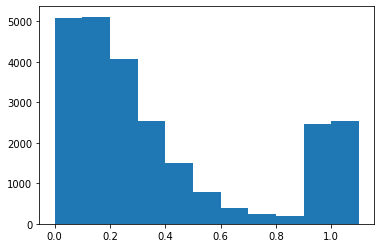

In [22]:
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [23]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 18301
Percentage of orders with a percent error lower than 0.5: 0.73


In [24]:
differences = []

for idx, val in enumerate(inv_y_test):
    differences.append(np.abs(val[0]-inv_test_pred[idx][0]))

In [25]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [26]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.26
Percentage of orders predicted correctly within 3 days: 0.53
Percentage of orders predicted correctly within 5 days: 0.7
Percentage of orders predicted correctly within 7 days: 0.82
